In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import datediff, to_date, lit, to_timestamp, col
from pyspark.sql.types import DateType

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [3]:
userProfile = spark.read.csv("data/users/public_users.csv", header = True)
#egoTimeline1 = spark.read.csv("data/users/public_users_timelines_1.csv", header = True)
#egoTimeline2 = spark.read.csv("data/users/public_users_timelines_2.csv", header = True)
#egoTimeline = egoTimeline1.union(egoTimeline2)

userProfile = userProfile.filter("followers_count >= 1" or "following_count >= 1")

temp = userProfile.withColumn("record_date",userProfile['created_at'].cast(DateType()))
userProfileWithTime = temp.withColumn("days", datediff(to_date(lit("2020-12-12")),'record_date'))

userProfileWithTime = userProfileWithTime.withColumn("dailyTweetsAverage",lit(userProfileWithTime.tweet_count/userProfileWithTime.days))

In [4]:
userProfileWithTimePandas = userProfileWithTime.toPandas()
userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["followers_count"].str.isdigit() == True]
userProfileWithTimePandas["followers_count"] = userProfileWithTimePandas["followers_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["following_count"].str.isdigit() == True]
userProfileWithTimePandas["following_count"] = userProfileWithTimePandas["following_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["tweet_count"].str.isdigit() == True]

In [8]:
egoTimeline1=pd.read_csv("data/users/public_users_timelines_1.csv",lineterminator='\n')

In [9]:
egoTimeline2=pd.read_csv("data/users/public_users_timelines_2.csv",lineterminator='\n')

In [10]:
egoTimeline2.columns

Index(['user_id', 'user', 'id', 'created_at', 'text', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'source', 'truncated', 'coordinates', 'place',
       'is_quote_status', 'quoted_status_id', 'quoted_status', 'quote_count',
       'retweeted_status', 'retweet_count', 'favorite_count', 'entities',
       'extended_entities', 'possibly_sensitive', 'lang'],
      dtype='object')

In [11]:
egoTimeline_pd_all=pd.concat([egoTimeline1[['user_id','entities']],egoTimeline2[['user_id','entities']]],axis=0)

In [12]:
egoTimeline_pd_all.user_id.value_counts()

1212342841    3800
36097879      3800
2396176568    3800
1330759578    3800
136886942     3799
              ... 
2566081733       1
2876982061       1
1366213777       1
2472505256       1
173128092        1
Name: user_id, Length: 13635, dtype: int64

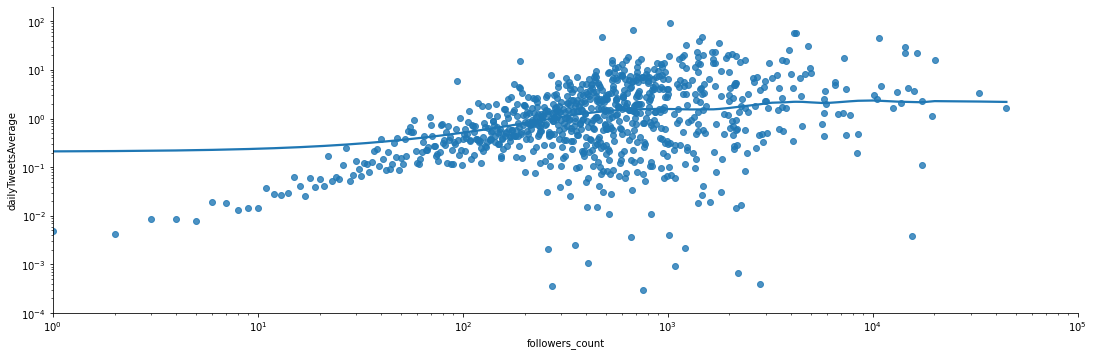

In [13]:
t = userProfileWithTimePandas.groupby("followers_count").mean().reset_index()
splot = sns.lmplot(x="followers_count", y="dailyTweetsAverage", data=t,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


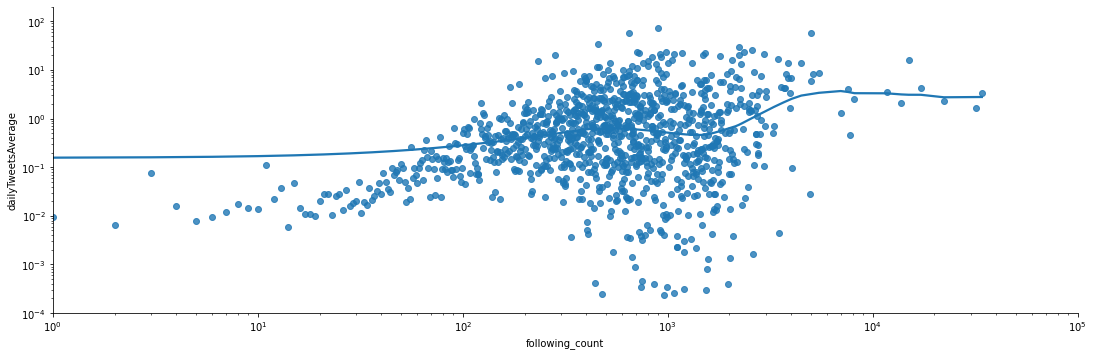

In [14]:
d = userProfileWithTimePandas.groupby("following_count").mean().reset_index()

splot = sns.lmplot(x="following_count", y="dailyTweetsAverage", data=d,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


In [15]:
followingCor = np.log(userProfileWithTimePandas["following_count"])
followersCor = np.log(userProfileWithTimePandas["followers_count"])
dailyTweetCor= np.log(userProfileWithTimePandas["dailyTweetsAverage"])
tweetCountCor = np.log(userProfileWithTimePandas["tweet_count"].astype(int))


data = {'DailyTweetsAverage':dailyTweetCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor1 = pd.DataFrame(data = data)
print(cor1.corr( method= 'pearson'))

data2 = {'TweetsCount':tweetCountCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor2 = pd.DataFrame(data = data2)
print(cor2.corr( method= 'pearson'))

                    DailyTweetsAverage  FollowersCount  Following_count
DailyTweetsAverage            1.000000        0.744386         0.613695
FollowersCount                0.744386        1.000000         0.723578
Following_count               0.613695        0.723578         1.000000
                 TweetsCount  FollowersCount  Following_count
TweetsCount         1.000000        0.747128         0.610013
FollowersCount      0.747128        1.000000         0.723578
Following_count     0.610013        0.723578         1.000000


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# dailyTweetsAverage (number of friends)

In [18]:
egoTimeline_pd_all.to_csv('egoTimeline_pd_all.csv')

In [33]:
#egoTimeline_pd_all=spark.read.csv('egoTimeline_pd_all.csv',header=True)
egoTimeline_pd_all=pd.read_csv('egoTimeline_pd_all.csv')

In [28]:
#egoTimeline_pd_all=egoTimeline_pd_all.toPandas()

In [34]:
egoTimeline_pd_all=egoTimeline_pd_all.drop(['Unnamed: 0'],axis=1)

In [35]:
egoTimeline_pd_all.head()

,user_id,entities
0,129007523,"{'hashtags': [], 'symbols': [], 'user_mentions..."
1,32670411,"{'hashtags': [], 'symbols': [], 'user_mentions..."
2,555533734,"{'hashtags': [], 'symbols': [], 'user_mentions..."
3,555533734,"{'hashtags': [], 'symbols': [], 'user_mentions..."
4,555533734,"{'hashtags': [{'text': 'FeralAtHeart', 'indice..."


In [38]:
#get ids that was mentioned by user_id in timeline
import ast
def get_id_of_user(egoTimeline_pd_all):
    a=egoTimeline_pd_all.entities.apply(ast.literal_eval)
    b=a.apply(lambda x: x['user_mentions'])
    idd=b.apply(lambda x: -1 if not x else x[0]['id'])
    return idd

In [39]:
#get id that was mentioned by user_id in timeline
mentioned_id=get_id_of_user(egoTimeline_pd_all)
user_id_and_mentioned_id=pd.concat([egoTimeline_pd_all.user_id,mentioned_id],axis=1)

In [40]:
user_id_and_mentioned_id.to_csv('user_id_and_mentioned_id.csv',index=False)

In [6]:
user_id_and_mentioned_id=pd.read_csv('user_id_and_mentioned_id.csv')

In [7]:
#drop cases when user mentione himself
user_id_and_mentioned_id=user_id_and_mentioned_id[user_id_and_mentioned_id.user_id!=user_id_and_mentioned_id.entities]

In [8]:
user_id_and_mentioned_id.head(10)

,user_id,entities
0,129007523,-1
1,32670411,-1
2,555533734,-1
3,555533734,-1
4,555533734,-1
5,555533734,-1
7,555533734,-1
8,555533734,-1
9,555533734,-1
10,555533734,-1


In [9]:
#filter on users that didn't mention anyone
user_id_and_mentioned_id=user_id_and_mentioned_id[user_id_and_mentioned_id.entities!=-1]
user_id_and_count_mentioned_id=user_id_and_mentioned_id.groupby(['user_id','entities']).size().reset_index()

In [10]:
#number_of_mentioned_id  - how much time that person was mentioned in ego's timeline
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.rename({'entities':'mentioned_id','0':'number_of_mentioned_id'},axis=1)

In [11]:
#rename columns
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.rename({0:'number_of_mentioned_id'},axis=1)

In [12]:
#user_id - ego's id, mentioned_id - user's id that was mentioned by ego, number_of_mentioned_id - how much time that person was mentioned in ego's timeline
user_id_and_count_mentioned_id.head()

,user_id,mentioned_id,number_of_mentioned_id
0,6368722,76133,1
1,6368722,202003,2
2,6368722,662323,1
3,6368722,678953,1
4,6368722,768632,1


In [13]:
user_id_and_count_mentioned_id.to_csv('user_id_and_count_mentioned_id.csv',index=False)

In [14]:
#Friend is defined as a user who has been mentioned at least twice in an ego’s timeline.
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id[user_id_and_count_mentioned_id.number_of_mentioned_id>=2]

In [15]:
#change type to oin
user_id_and_count_mentioned_id.user_id=user_id_and_count_mentioned_id.user_id.astype(str)

In [16]:
#join with dailyTweetsAverage
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.merge(userProfileWithTimePandas[['id','dailyTweetsAverage']],
                                                                    left_on='user_id',right_on='id', how='inner')

In [17]:
#look at data
user_id_and_count_mentioned_id.head()

,user_id,mentioned_id,number_of_mentioned_id,id,dailyTweetsAverage
0,6368722,202003,2,6368722,0.226556
1,6368722,972651,2,6368722,0.226556
2,6368722,4354831,8,6368722,0.226556
3,6368722,6457452,7,6368722,0.226556
4,6368722,6730222,2,6368722,0.226556


In [18]:
userProfileWithTimePandas.id.nunique()

18135

In [19]:
user_id_and_count_mentioned_id.user_id.nunique()

5496

In [20]:
#count number of friends by user
a=user_id_and_count_mentioned_id.groupby('user_id').agg({'mentioned_id':lambda x: x.count(),'dailyTweetsAverage':lambda x: x.mean()}).reset_index()


In [21]:
a=a.drop_duplicates()

In [22]:
a.shape

(5496, 3)

In [23]:
a=a.rename({'mentioned_id':'number of friends'},axis=1)

In [25]:
b=a.groupby('number of friends').dailyTweetsAverage.mean().reset_index()

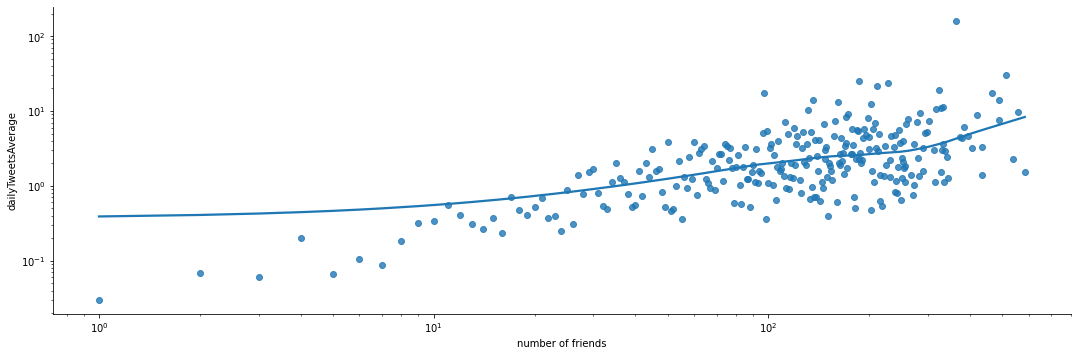

In [26]:
#plot 

splot = sns.lmplot(x="number of friends", y="dailyTweetsAverage", data=b,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
"""plt.ylim(0.0001, 200)
plt.xlim(1, 100000)"""

 
plt.show()

In [28]:
c=b[['number of friends','dailyTweetsAverage']].apply(lambda x: np.log(x))

In [29]:
print(c.corr( method= 'pearson'))

                    number of friends  dailyTweetsAverage
number of friends             1.00000             0.68837
dailyTweetsAverage            0.68837             1.00000
